# Strain Measurement Example

This example demonstrates how to process experimental strain data and calculate forces. This example is based on the laboratory testing of a tidal turbine blade TODO - CITE. The blade root is mounted to a thin-walled, rectangular block with four, 90 degree strain rosettes (top, bottom, left, right). Each strain rosette has a local coordinate system, denoted in the figure below. 

<div>
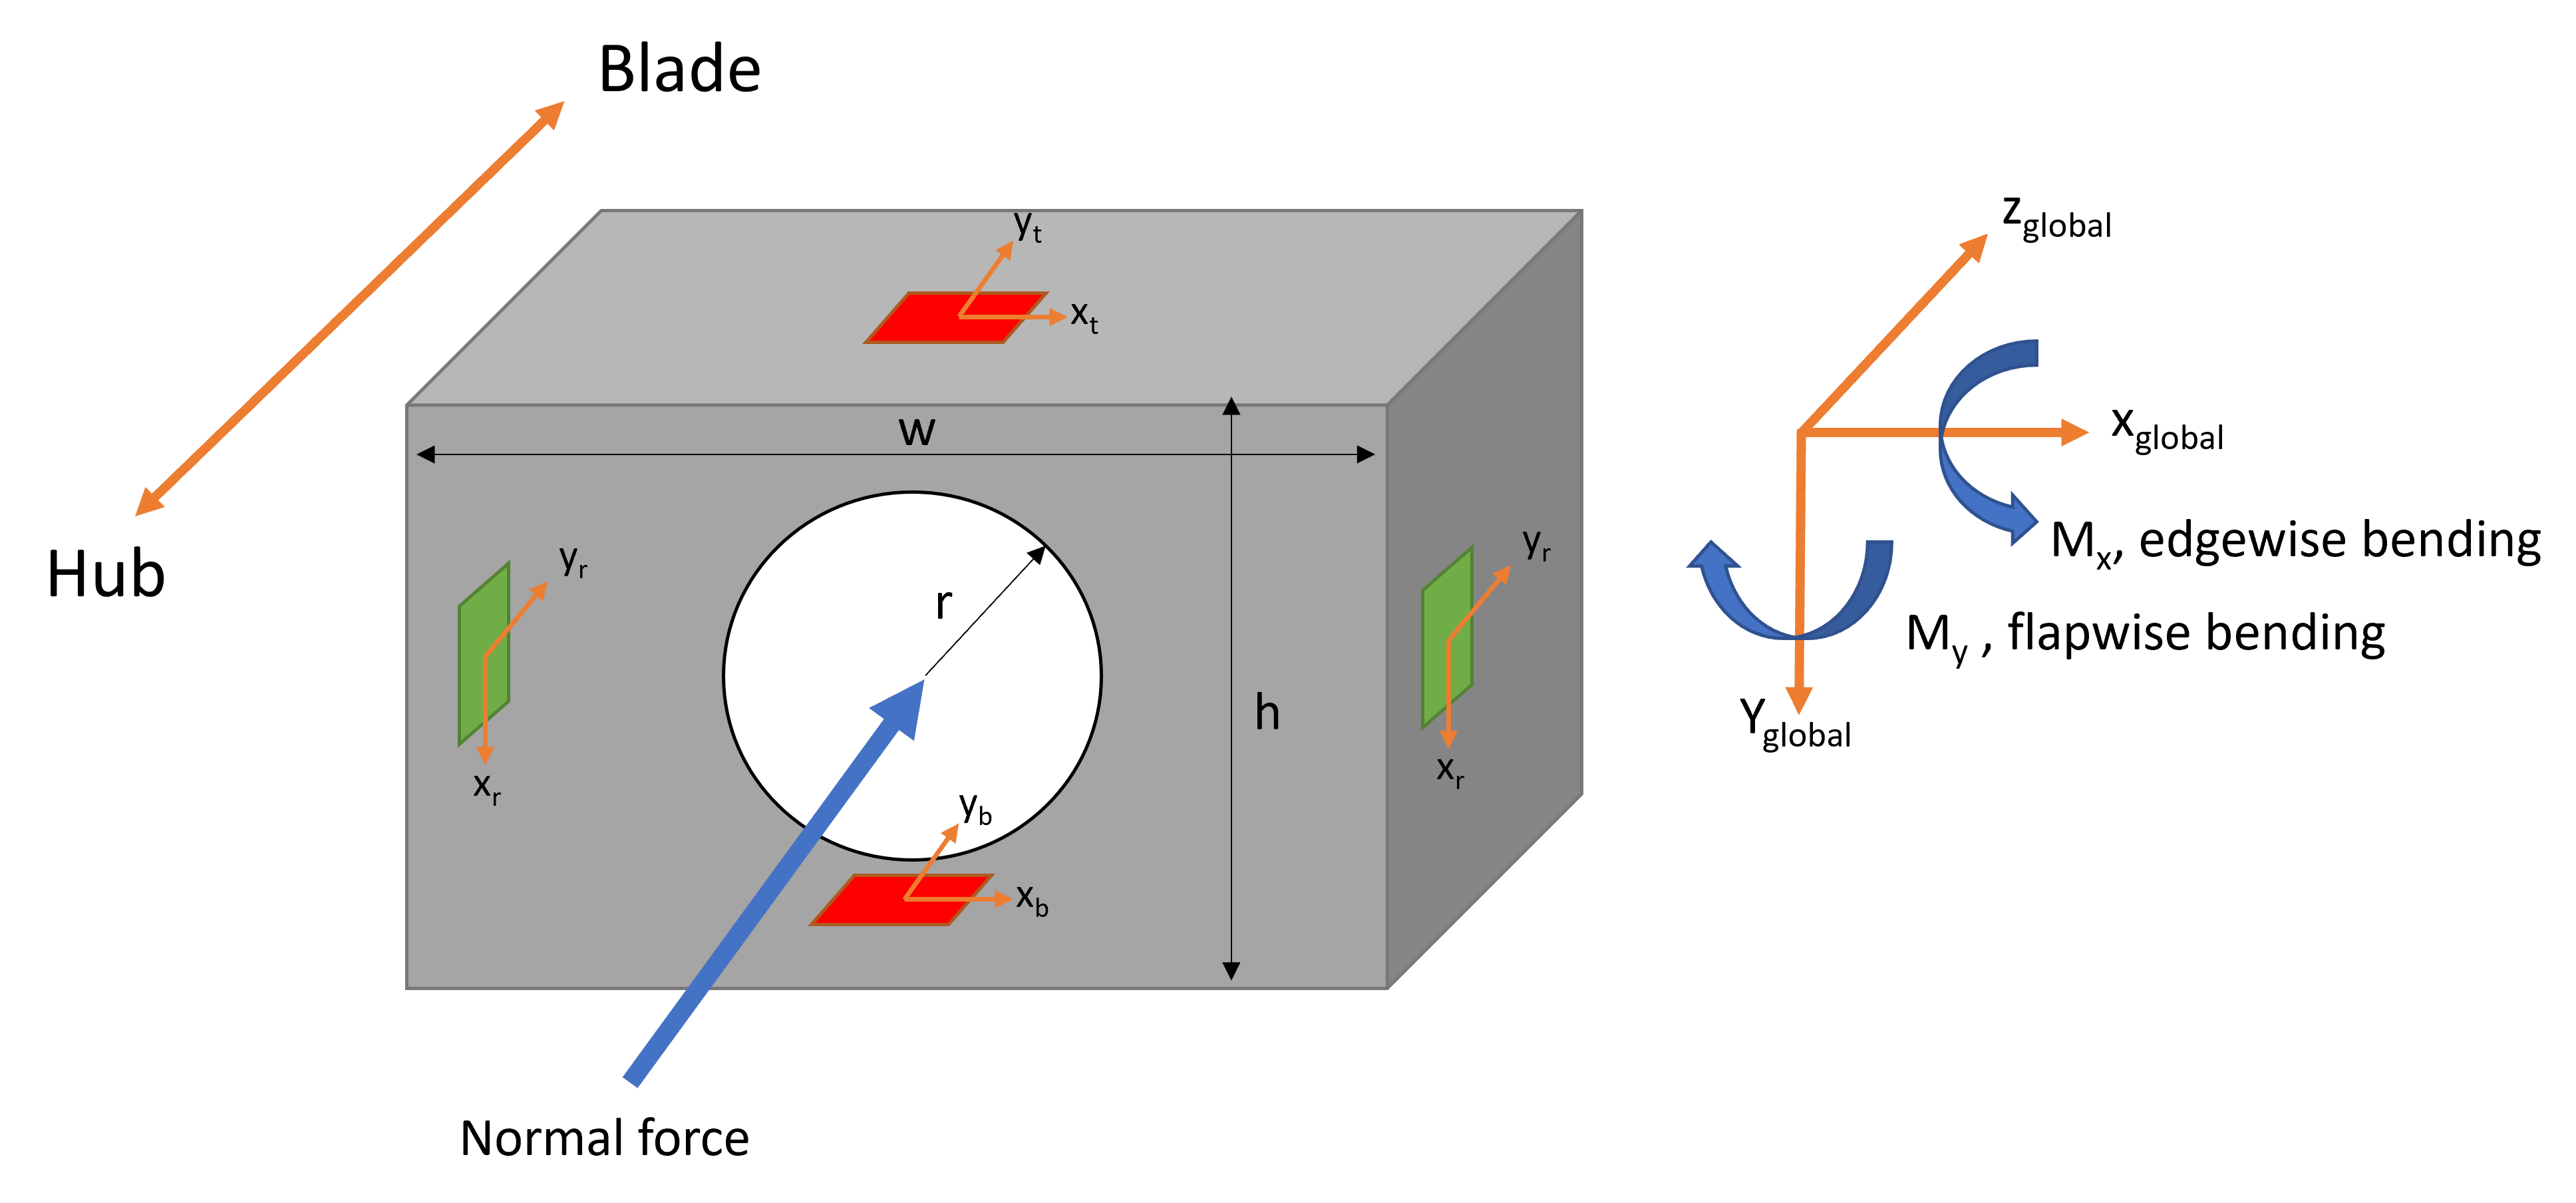
</div>

We will start by importing the necessary python packages (`pandas`, `xarray`, `numpy`). Due to the highly variable nature of experimental configurations, these functions are not included in an MHKiT module. This example can be used as a guide to process strain data from other experimental configurations. Pandas is used to read the CSV file robustly. xarray is used to handle the multidimensional data easily. 

In [1]:
import pandas as pd
import xarray as xr
import numpy as np

## Load strain data and map rosettes to TBLR (top, bottom, left, right)
The strain data is contained in a CSV file. Time is the first column. Strain data is ordered by rosette and each rosette corresponds to three strain measurements (ea, eb, ec). Rosettes 1, 2, 3, 4 correspond to the top, bottom, left, and right rosettes in the global coordinate system.

In [2]:
raw_data = pd.read_csv(
    "data/strain/R17.csv",
    sep=",",
    header=None,
    index_col=0,
    names=[
        "time",
        "ec_1",
        "eb_1",
        "ea_1",
        "ec_2",
        "eb_2",
        "ea_2",
        "ec_3",
        "eb_3",
        "ea_3",
        "ec_4",
        "eb_4",
        "ea_4",
    ],
)

raw_data

,ec_1,eb_1,ea_1,ec_2,eb_2,ea_2,ec_3,eb_3,ea_3,ec_4,eb_4,ea_4
time,,,,,,,,,,,,
0.00,0.379,0.208,2.926,-0.623,1.160,0.270,0.309,1.877,-0.038,2.376,-0.312,-1.811
0.01,-2.578,1.360,1.523,0.192,-1.943,1.429,3.128,1.372,1.539,0.018,0.689,-1.305
0.02,0.839,1.862,2.198,-0.820,-1.347,0.785,1.124,2.687,0.594,0.370,-0.465,0.039
0.03,-5.249,-0.961,1.248,-0.881,-1.231,1.252,0.893,0.718,0.024,0.654,0.489,0.989
0.04,-3.377,1.078,2.092,-0.504,-0.504,1.268,-0.821,-0.989,0.577,-4.508,-0.312,0.514
...,...,...,...,...,...,...,...,...,...,...,...,...
1407.35,13.287,3.473,-18.279,-2.061,-0.428,5.256,25.280,11.563,25.195,-0.634,-21.175,-37.170
1407.36,16.541,5.171,-18.800,-3.036,-5.307,7.300,23.141,14.141,26.548,-2.776,-20.132,-35.298
1407.37,16.722,5.529,-15.892,-2.061,-4.517,6.495,22.500,13.679,25.744,-1.433,-19.965,-38.288


In [3]:
# Map all strain data to an xarray Dataset with variables ea, eb, ec with dimensions time, rosette
# Create an additional coordinate "rosetteName" for the "rosette" dimension to better keep track of rosette position in the global coordinate system.
data = xr.Dataset(data_vars={"ea": (['time','rosette'], raw_data[['ea_1', 'ea_2', 'ea_3', 'ea_4']]),
                             "eb": (['time','rosette'], raw_data[['eb_1', 'eb_2', 'eb_3', 'eb_4']]),
                             "ec": (['time','rosette'], raw_data[['ec_1', 'ec_2', 'ec_3', 'ec_4']]),
                            },
                 coords = {"time": raw_data.index,
                           "rosette": [1, 2, 3, 4],
                           "rosetteName": ("rosette", ["top", "bottom", "left", "right"]),
                          },
                 )
data

<xarray.Dataset> Size: 15MB
Dimensions:      (time: 140740, rosette: 4)
Coordinates:
  * time         (time) float64 1MB 0.0 0.01 0.02 ... 1.407e+03 1.407e+03
  * rosette      (rosette) int64 32B 1 2 3 4
    rosetteName  (rosette) <U6 96B 'top' 'bottom' 'left' 'right'
Data variables:
    ea           (time, rosette) float64 5MB 2.926 0.27 -0.038 ... 26.64 -38.96
    eb           (time, rosette) float64 5MB 0.208 1.16 1.877 ... 12.31 -21.14
    ec           (time, rosette) float64 5MB 0.379 -0.623 0.309 ... 24.27 -1.606

## Define system parameters


In [4]:
width = 44.6024 / 1000  # width of strain gauge cube holding the blade root [m]
height = 44.6024 / 1000  # height of strain gauge cube holding the blade root [m]
radius = 15.24 / 1000  # radius of blade root [m]
elastic_modulus = 197e9  # [Pa]
shear_modulus = 77.4e9  # [Pa]
blade_span = 0.86868  # [m]

## Calculate axial and shear strain
### 90 degree rosettes
We now have all strain data contained in a convenient xarray Dataset with dimensions corresponding to time and rosette, and variables corresponding to measured strain. The local y-axis of each rosette corresponds to the global z-axis. Each rosette is locally oriented like the following coordinate system.

<div>
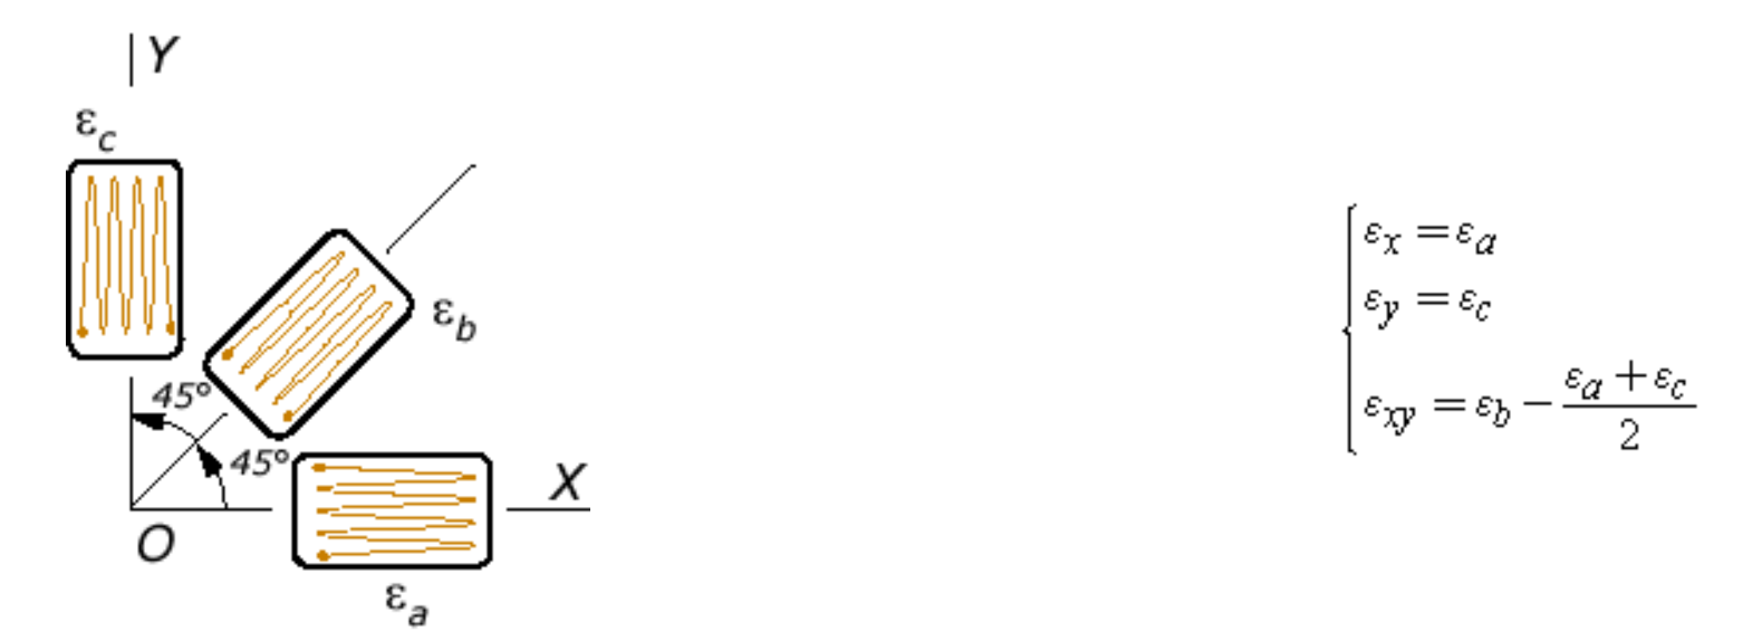
</div>

Now we can calculate the axial strains and shear strain for each 90 degree rosette. All rosettes are oriented in this way so a Dataset coordinate corresponding to rosette index is convenient here.

In [5]:
data["axial_strain_x"] = data["ea"]
data["axial_strain_y"] = data["ec"]
data["shear_strain"] = data["eb"] - (data["ea"] + data["ec"]) / 2
data

<xarray.Dataset> Size: 28MB
Dimensions:         (time: 140740, rosette: 4)
Coordinates:
  * time            (time) float64 1MB 0.0 0.01 0.02 ... 1.407e+03 1.407e+03
  * rosette         (rosette) int64 32B 1 2 3 4
    rosetteName     (rosette) <U6 96B 'top' 'bottom' 'left' 'right'
Data variables:
    ea              (time, rosette) float64 5MB 2.926 0.27 ... 26.64 -38.96
    eb              (time, rosette) float64 5MB 0.208 1.16 ... 12.31 -21.14
    ec              (time, rosette) float64 5MB 0.379 -0.623 ... 24.27 -1.606
    axial_strain_x  (time, rosette) float64 5MB 2.926 0.27 ... 26.64 -38.96
    axial_strain_y  (time, rosette) float64 5MB 0.379 -0.623 ... 24.27 -1.606
    shear_strain    (time, rosette) float64 5MB -1.445 1.337 ... -13.15 -0.857

### Alternate equations for 120 degree rosettes
If we had 120 degree rosettes, we could calculate the axial and shear strains from the measured strains in a similar manner using the respective equations:

In [6]:
# Assuming eb aligns with the local y, and that ea and ec are +60 or -60 degrees from eb respectively.
# data["axial_strain_x"] = 2 / 3 * (data["ea"] - data["eb"] / 2 + data["ec"])
# data["axial_strain_y"] = data["eb"]
# data["shear_strain"] = 1 / np.sqrt(3) * (data["ea"] - data["ec"])

## Calculate loads from strain
### Define equations for normal force, moment, and torsion
Because the strain is measured on a rectangular prism, the normal force, moment and torsion use similar equations. We first create three functions that calculate the normal force, moment, and torsion given some strain and geometrical inputs. The torsion is calculated for each rosette. The normal force and moment are calculated using rosette pairs to eliminate the effect of the bending moment on axial strain when calculating the normal force, and vice versa.

In [7]:
def calculate_normal(axial_strain_1, axial_strain_2, elastic_modulus, shear_modulus, width, height, radius):
    normal = 0.5 * (axial_strain_1 + axial_strain_2) * \
             elastic_modulus * (width * height - np.pi * radius**2)
    return normal

def calculate_moment(axial_strain_1, axial_strain_2, elastic_modulus, shear_modulus, width, height, radius):
    moment = (axial_strain_1 - axial_strain_2) / height * \
             elastic_modulus * (width * height**3 / 12 - np.pi * radius**4 / 4)
    return moment

def calculate_torsion(shear_strain, shear_modulus, width, height, radius):
    polar_moment_of_inertia = (width**3 * height + width * height**3) / 12 - np.pi * radius**4 / 2
    torsion = shear_strain * shear_modulus * polar_moment_of_inertia / (height / 2)
    return torsion

### Calculate normal force and bending moments
We will use the three custom functions to calculate the normal force and bending moments with the top and bottom rosette pair, and then based on the left and right rosette pair.

In [8]:
# Top and bottom rosettes
normal_topBottom = calculate_normal(data.sel(rosette=1)["axial_strain_y"], data.sel(rosette=2)["axial_strain_y"], 
                                    elastic_modulus, shear_modulus, width, height, radius)
moment_x = calculate_moment(data.sel(rosette=1)["axial_strain_y"], data.sel(rosette=2)["axial_strain_y"], 
                            elastic_modulus, shear_modulus, width, height, radius)

# Right and left rosettes
# note that height and width inputs are switched due to the different orientation
normal_rightLeft = calculate_normal(data.sel(rosette=4)["axial_strain_y"], data.sel(rosette=3)["axial_strain_y"], 
                                    elastic_modulus, shear_modulus, height, width, radius)
moment_y = calculate_moment(data.sel(rosette=4)["axial_strain_y"], data.sel(rosette=3)["axial_strain_y"], 
                            elastic_modulus, shear_modulus, height, width, radius)

### Calculate torsion
Next we will calculate the torsion using the shear strain of each rosette and find the average torsion load.

In [9]:
torsion_top = calculate_torsion(data.sel(rosette=1)["shear_strain"], shear_modulus, width, height, radius)
torsion_bottom = calculate_torsion(data.sel(rosette=2)["shear_strain"], shear_modulus, width, height, radius)

# note that height and width inputs are switched due to the different orientation
torsion_right = calculate_torsion(data.sel(rosette=3)["shear_strain"], shear_modulus, height, width, radius)
torsion_left = calculate_torsion(data.sel(rosette=4)["shear_strain"], shear_modulus, height, width, radius)

# Calculate the average torsion
torsion = (torsion_top + torsion_bottom + torsion_right + torsion_left)/4

### Rotate loads to blade coordinate system
It is possible that the blade coordinate system is not aligned to the global coordinate system. This could be due to limitations of the experimental configuration or intentional to enable the use of strain gauges with larger loads.

<div>
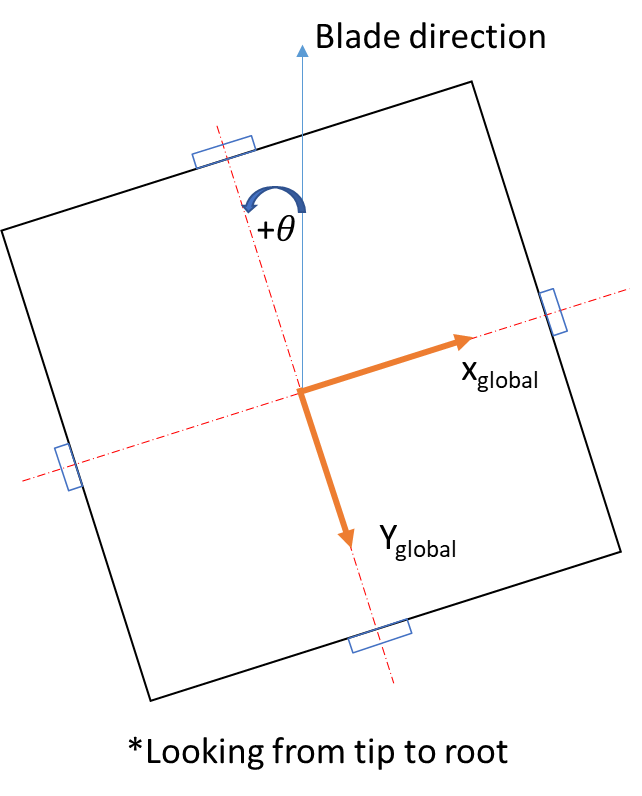
</div>

In this case, we can transform the bending moment from the global coordinate system to align with the blade's flapwise direction.

In [10]:
angle = 0 * np.pi / 180 # rotation angle of the root
moment_flapwise = moment_x * np.cos(angle) - moment_y * np.sin(angle)
moment_edgewise = moment_x * np.sin(angle) + moment_y * np.cos(angle)